In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import plotly.graph_objects as go
fp = 'mimiciii_data/'

In [ ]:
# MIMIC III data
patients = pd.read_csv(fp+'PATIENTS.csv.gz')
admissions = pd.read_csv(fp+'ADMISSIONS.csv.gz')
labevents = pd.read_csv(fp+'LABEVENTS.csv.gz')
diagnoses_icd = pd.read_csv(fp+'DIAGNOSES_ICD.csv.gz')
d_icd_diagnoses = pd.read_csv(fp+'D_ICD_DIAGNOSES.csv.gz')
callout = pd.read_csv(fp+'CALLOUT.csv.gz')

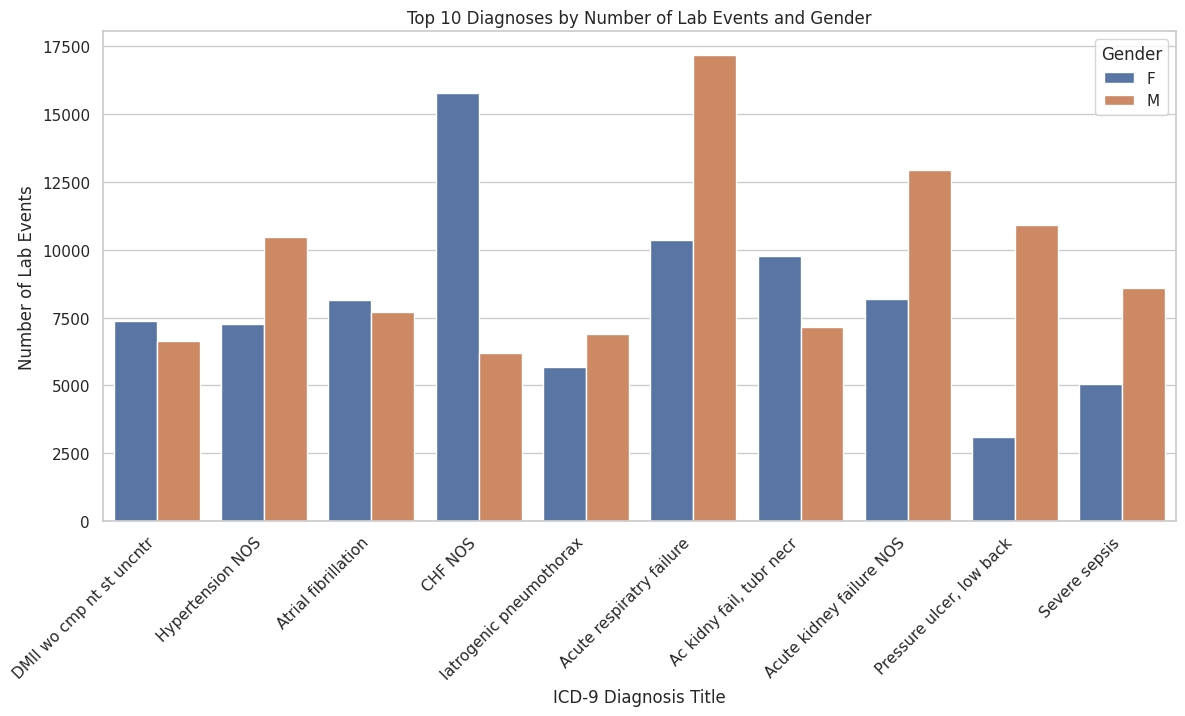

In [51]:
# Graph 1
# Motivation: Observe disease which leads to most lab tests
# From labevents, capture the disease which leads to most labevents, based on gender

# Merge labevents with admissions to get gender
labs = labevents.merge(admissions[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')

# Merge with diagnoses to get ICD codes
labs_diag = labs.merge(diagnoses_icd[['subject_id', 'hadm_id', 'icd9_code']], 
                       on=['subject_id', 'hadm_id'], how='inner')

# Merge with patients to get gender
labs_diag = labs_diag.merge(patients[['subject_id', 'gender']], on='subject_id', how='left')

# Count lab events per icd9_code and Gender
lab_counts = labs_diag.groupby(['icd9_code', 'gender']).size().reset_index(name='labevent_count')

# Select top diagnoses by total volume
top_codes = (lab_counts.groupby('icd9_code')['labevent_count']
                        .sum()
                        .nlargest(10)
                        .index)

# Filter to just those
lab_counts_top = lab_counts[lab_counts['icd9_code'].isin(top_codes)]

# Load icd9_code mapping
icd9_map = d_icd_diagnoses[['icd9_code', 'short_title']]
lab_counts_top = lab_counts_top.merge(icd9_map, on='icd9_code', how='left')


# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=lab_counts_top, x='short_title', y='labevent_count', hue='gender')
plt.title('Top 10 Diagnoses by Number of Lab Events and Gender')
plt.ylabel('Number of Lab Events')
plt.xlabel('ICD-9 Diagnosis Title')
plt.legend(title='Gender')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

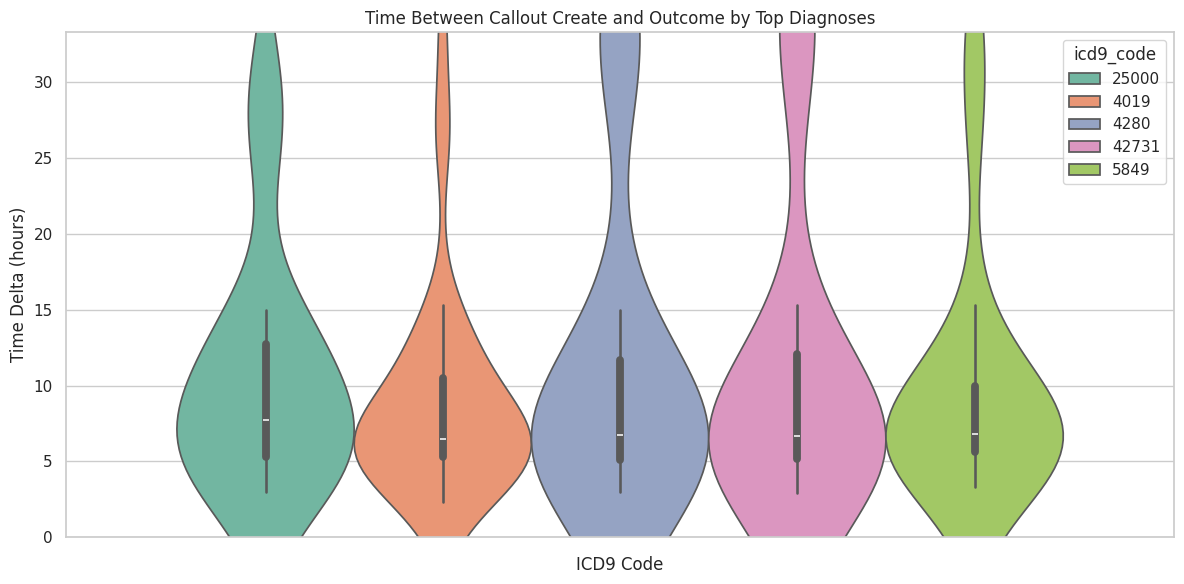

In [52]:
# Graph 2
# Motivation: which diagnosis leads to most delay in callout
# Time delta range between outcometime and createtime for callout table records 
# based on diagnosis data available in admissions table

# Clean time columns
callout['createtime'] = pd.to_datetime(callout['createtime'])
callout['outcometime'] = pd.to_datetime(callout['outcometime'])

# Calculate time delta in hours
callout['delay_hours'] = (callout['outcometime'] - callout['createtime']).dt.total_seconds() / 3600
callout = callout[callout['delay_hours'] >= 0]  # remove negative delays

# Join with diagnoses
call_diag = callout.merge(diagnoses_icd[['hadm_id', 'icd9_code']], on='hadm_id', how='left')

# Get top 5 frequent diagnoses
top_diagnoses = (call_diag['icd9_code'].value_counts().nlargest(5).index)
call_diag_top = call_diag[call_diag['icd9_code'].isin(top_diagnoses)]

# Join with diagnosis names
diag_map = d_icd_diagnoses[['icd9_code', 'short_title']]
call_diag_top = call_diag_top.merge(diag_map, on='icd9_code', how='left')

# Plot violin 
plt.figure(figsize=(12, 6))
sns.violinplot(data=call_diag_top, hue='icd9_code', y='delay_hours', palette='Set2', inner='box', legend=True)
plt.title("Time Between Callout Create and Outcome by Top Diagnoses")
plt.xlabel("ICD9 Code")
plt.ylabel("Time Delta (hours)")
plt.ylim(0, call_diag_top['delay_hours'].quantile(0.95))  # Optional: cap outliers for readability
plt.tight_layout()
plt.show()

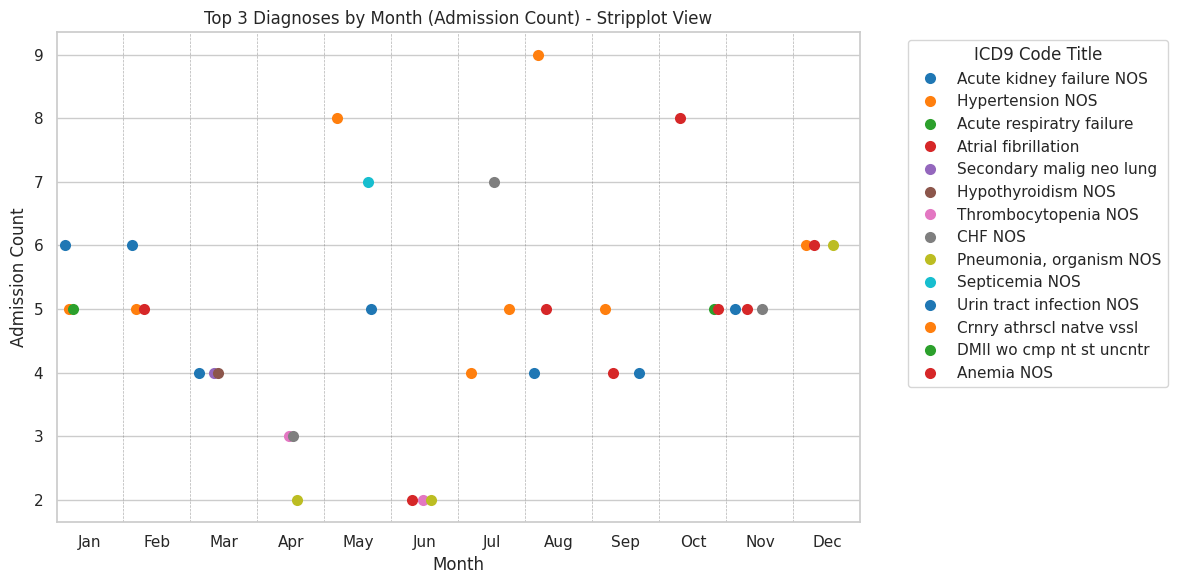

In [56]:
# Graph 3
# Motivation: Capture any potential pattern in diseases treated and the month they r treated in 
# From admissions table, capture the top 3 diagnosis for each month and 
# see for any emerging pattern

# Convert admittime to datetime and extract month
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['month'] = admissions['admittime'].dt.month

# Join with diagnoses
adm_diag = admissions.merge(diagnoses_icd[['subject_id', 'hadm_id', 'icd9_code']], 
                            on=['subject_id', 'hadm_id'], how='inner')

# Count diagnosis occurrences per month
monthly_diag_counts = (adm_diag.groupby(['month', 'icd9_code'])
                              .size()
                              .reset_index(name='count'))

# For each month, get top 3 diagnoses
top3_by_month = (monthly_diag_counts.sort_values(['month', 'count'], ascending=[True, False])
                                     .groupby('month')
                                     .head(3))

# Map icd9_code to title
icd_map = d_icd_diagnoses[['icd9_code', 'short_title']]
top3_by_month = top3_by_month.merge(icd_map, on='icd9_code', how='left')

#  Map month to month names
month_order = list(calendar.month_abbr)[1:]  # Jan to Dec
top3_by_month['month_name'] = top3_by_month['month'].apply(lambda x: calendar.month_abbr[x])

# Plot with stripplot
plt.figure(figsize=(12, 6))
ax = sns.stripplot(data=top3_by_month, x='month_name', y='count', hue='short_title',
              jitter=True, size=8, palette='tab10', dodge=True)

for i in range(len(month_order) - 1):
    ax.axvline(i + 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

plt.title("Top 3 Diagnoses by Month (Admission Count) - Stripplot View")
plt.xlabel("Month")
plt.ylabel("Admission Count")
plt.legend(title='ICD9 Code Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_130034/1975554025.py:25: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



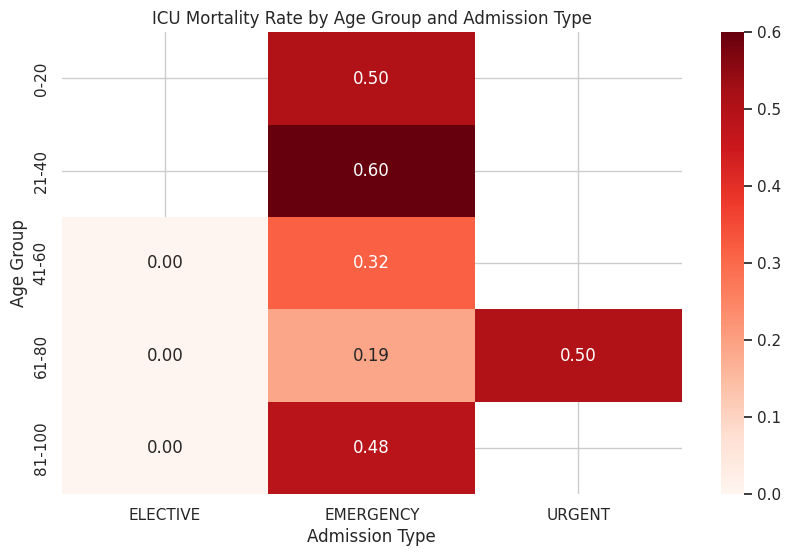

In [60]:
# Graph 4
# Motivation : Capture mortality rate across age and type of admission

# Preprocess age and group into bins
def calculate_age(dob, admittime):
    dob_date = datetime.strptime(str(dob), "%Y-%m-%d %H:%M:%S")
    admittime_date = datetime.strptime(str(admittime), "%Y-%m-%d %H:%M:%S")
    age = (admittime_date - dob_date).days // 365
    return age

# Merge to get DOB for each admission (many-to-one merge)
adm = admissions.merge(patients[['subject_id', 'dob']], on='subject_id', how='left')

# Calculate age
adm['age'] = adm.apply(lambda row: calculate_age(row["dob"], row["admittime"]), axis=1)

# Cap unrealistic ages
adm = adm[adm['age'] < 100]

# Bucket age
adm['age_group'] = pd.cut(adm['age'], bins=[0, 20, 40, 60, 80, 100], 
                          labels=["0-20", "21-40", "41-60", "61-80", "81-100"])

# Pivot mortality rate by age group and admission type
heatmap_data = adm.pivot_table(
    index="age_group",
    columns="admission_type",
    values="hospital_expire_flag",
    aggfunc="mean"
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Reds", fmt=".2f")
plt.title("ICU Mortality Rate by Age Group and Admission Type")
plt.ylabel("Age Group")
plt.xlabel("Admission Type")
plt.show()

In [ ]:
# Graph 5 
# Using plotly visualizes patient flow paths from admission type to outcome.
flows = admissions.groupby(['admission_type', 'insurance', 'discharge_location']).size().reset_index(name='count')

labels = list(set(flows['admission_type']) | set(flows['insurance']) | set(flows['discharge_location']))
label_map = {k: v for v, k in enumerate(labels)}

source = flows['admission_type'].map(label_map)
intermediate = flows['insurance'].map(label_map)
target = flows['discharge_location'].map(label_map)

# Split into 2 links: Admission → Insurance, Insurance → Discharge
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(
        source=source.tolist() + intermediate.tolist(),
        target=intermediate.tolist() + target.tolist(),
        value=flows['count'].tolist() + flows['count'].tolist()
    ))])

fig.update_layout(title_text="Patient Flow: Admission → Insurance → Discharge", font_size=10)
fig.show()